### This code is used to train the 2 features RoBERTa model

In [1]:
import nltk
import pandas as pd
from nltk.stem import WordNetLemmatizer

# Import STOPWORDS from NLTK
from nltk.corpus import stopwords

import string, re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/VarshithaCVasireddy/datasets/main/dataset_cleaned.csv?token=GHSAT0AAAAAACADFJF5QKAKY7JFJT42OCLWZCEVC3A')

time: 1.81 s (started: 2023-04-23 02:46:14 +00:00)


In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

time: 743 ms (started: 2023-04-23 02:46:25 +00:00)


In [10]:
data.title = [Text.lower() for Text in data.title]
def sentence_tokenize(text: str):
    return nltk.sent_tokenize(text)

data['Sentences'] = data['title'].apply(sentence_tokenize)

time: 1.61 s (started: 2023-04-23 02:49:08 +00:00)


In [11]:
def word_tokenize(sentences: list[str]):
    words: list[str] = []
    lemmatizer = WordNetLemmatizer()
    for sent in sentences:
        for word in nltk.word_tokenize(sent):
            if word not in stopwords.words('english') and word not in string.punctuation:
                word = re.sub(r"[^a-zA-Z0-9\s.-]", "", word)
                words.append(lemmatizer.lemmatize(word))

    return words 

data['Words'] = data['Sentences'].apply(word_tokenize)

time: 1min 11s (started: 2023-04-23 02:49:13 +00:00)


In [12]:
data['str1'] = [' '.join(doc) for doc in data.Words]
# Create a new column 'Diff_Charac' which counts the characters in the sentence title which are not alpha numerics and space
data['Diff_Charac'] = data['title'].apply(lambda x: sum(1 for char in x if not char.isalnum() and not char.isspace()))

time: 192 ms (started: 2023-04-23 02:50:25 +00:00)


In [14]:
# Create a new feature 'new_feature' by combining two existing features
data['new_feature'] = data['str1'] + ' ' + data['Diff_Charac'].astype(str)

time: 27.3 ms (started: 2023-04-23 03:13:33 +00:00)


In [16]:
data.to_csv('/content/drive/MyDrive/dataset_new_feature.csv')

time: 936 ms (started: 2023-04-23 03:14:07 +00:00)


In [18]:
from sklearn.model_selection import train_test_split
# Split the dataset into training, validation, and test sets
train_df, tmp_df = train_test_split(data, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42)

time: 31.2 ms (started: 2023-04-23 03:17:10 +00:00)


In [19]:
train_df.to_csv('/content/drive/MyDrive/train_df.csv')

time: 564 ms (started: 2023-04-23 03:17:19 +00:00)


In [20]:
val_df.to_csv('/content/drive/MyDrive/val_df.csv')

time: 97.5 ms (started: 2023-04-23 03:17:29 +00:00)


In [21]:
test_df.to_csv('/content/drive/MyDrive/test_df.csv')

time: 105 ms (started: 2023-04-23 03:17:36 +00:00)


In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Load the RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

In [24]:
# Encode the training, validation, and test sets
train_encodings = tokenizer(train_df['new_feature'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['new_feature'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['new_feature'].tolist(), truncation=True, padding=True)

# Convert 'Label' column to numeric labels
label_map = {'Fake': 0, 'Real': 1}
train_labels = [label_map[label] for label in train_df['label'].tolist()]
val_labels = [label_map[label] for label in val_df['label'].tolist()]
test_labels = [label_map[label] for label in test_df['label'].tolist()]

time: 18.5 s (started: 2023-04-23 03:22:48 +00:00)


In [25]:
# Create PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels)
)

time: 1.79 s (started: 2023-04-23 03:23:09 +00:00)


In [26]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=50,
    learning_rate=5e-5,
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'labels':torch.stack([item[2] for item in data])},
)

time: 7.92 s (started: 2023-04-23 03:23:44 +00:00)


In [27]:
# Train the model
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.690100,0.680034
100,0.239200,0.252007
150,0.272000,0.191816
200,0.200200,0.204867
250,0.162400,0.139967
300,0.242500,0.155319
350,0.158300,0.213232
400,0.279200,0.133540
450,0.256000,0.140541
500,0.167300,0.162282


TrainOutput(global_step=5082, training_loss=0.14004358675936365, metrics={'train_runtime': 2156.288, 'train_samples_per_second': 37.7, 'train_steps_per_second': 2.357, 'total_flos': 1963403042304060.0, 'train_loss': 0.14004358675936365, 'epoch': 3.0})

time: 35min 56s (started: 2023-04-23 03:24:07 +00:00)


In [28]:
label_map = {'Fake': 0, 'Real': 1}
# Evaluate the model on the test set
preds = trainer.predict(test_dataset)
pred_labels = preds.predictions.argmax(-1)

# Convert the true labels to integers
true_labels = [label_map[label] for label in test_df['label'].tolist()]

# Compute the accuracy and classification report
accuracy = accuracy_score(true_labels, pred_labels)
class_report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])

print(f"Accuracy for RoBERTa with 2 features: {accuracy}")
print(f"Classification Report:\n{class_report}")


Accuracy for RoBERTa with 2 features: 0.9683141036679869
Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.95      0.97      2667
        Real       0.96      0.98      0.97      3140

    accuracy                           0.97      5807
   macro avg       0.97      0.97      0.97      5807
weighted avg       0.97      0.97      0.97      5807

time: 16.1 s (started: 2023-04-23 04:00:04 +00:00)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

# Compute precision, recall, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Compute confusion matrix
confusion_mat = confusion_matrix(true_labels, pred_labels)

# Compute ROC AUC score
roc_auc = roc_auc_score(true_labels, pred_labels)

# Print results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(confusion_mat)
print(f"ROC AUC Score: {roc_auc}")

Precision: 0.9604361370716511
Recall: 0.9818471337579617
F1 Score: 0.9710236220472441
Confusion Matrix:
[[2540  127]
 [  57 3083]]
ROC AUC Score: 0.967114043069457
time: 59.6 ms (started: 2023-04-23 04:00:20 +00:00)


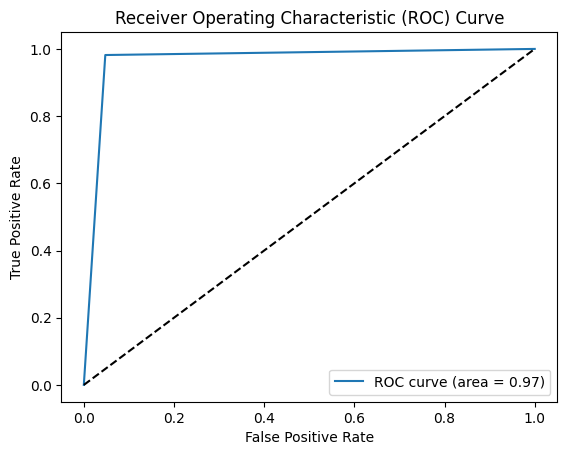

time: 431 ms (started: 2023-04-23 04:00:20 +00:00)


In [30]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [32]:
# from huggingface_hub import notebook_login

# notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# model.push_to_hub("News_Title_2features_RoBERTa")

In [ ]:
# tokenizer.push_to_hub("News_Title_2features_RoBERTa")